# U.T.3 Metodología del ML.
## Ajuste de problemas
### Sobreajuste
Si un modelo predice los datos mucho mejor en los de entrenamiento que en los de test,
es muy posible que sea un sobreajuste.
La posible razón es que nuestro modelo es muy complejo para los datos de entrenamiento.

Las soluciones más comunes para esto son:
- Conseguir más datos para entrenar el modelo.
- Elegir un modelo más simple.
- Introducir una penalización a la complejidad del modelo vía regularización.
- Reducir la dimensionalidad de los datos.
    - Eliminando características con baja varianza
    - Selección de características invariables
    - Con bosques aleatorios
    - Extracción de características

### Regularización
La regularización es una manera para manejar la colinealidad (alta correlación entre las características),
filtrar el ruido y prevenir el sobreajuste.

La correlación de dos atributos indica la semejanza entre ambas variables. Este valor va desde menos uno (-1)
hasta uno (1), siendo el cero el punto donde mayor independencia hay entre las variables y los extremos donde mayor.

Se puede detectar con la matriz de correlación

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(1)

x_1 = np.random.randn(10)
x_2 = np.random.randn(10)
x_3 = np.random.randn(10)

print(np.corrcoef(x_1, x_2).round(3))
print(np.corrcoef(x_1, x_3).round(3))
print(np.corrcoef(x_2, x_3).round(3))

[[1.    0.656]
 [0.656 1.   ]]
[[ 1.    -0.085]
 [-0.085  1.   ]]
[[ 1.    -0.179]
 [-0.179  1.   ]]


<AxesSubplot:>

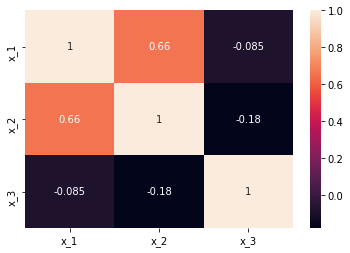

In [2]:
df = pd.DataFrame({"x_1":x_1, "x_2":x_2, "x_3":x_3})
sns.heatmap(df.corr(), annot=True)


El significado de los valores son los siguientes:
- Un valor cercano a 1, si crece uno crece el otro
- Un valor cercano a -1, si crece uno decrece el otro
- Un valor cercano a 0 no están correlacionados

La regularización introduce información adicional para penalizar los valores extremos de los parámetros.

Para que la regularización funcione es imprescindible que las características sean comparables (se hayan escalado).

**Tipos**
- La regularización **L2** reduce la complejidad del modelo penalizando los valores altos de los pesos, con lo que se tiende
a que los pesos sean cercanos a cero
- La regularización **L1** hace que muchos de los pesos valgan cero, con lo que el efecto es que algunas características
no cuentan y por tanto es una reducción de las mismas
- La regularización **Elástica**. A medio camino entre la regularización L1 y la L2 se encuentra la regularización elástica
Tiene un parámetro que determina la cantidad de regularización.En caso de valer 0, es equivalente la L2,
en caso de valer 1 es equivalente a L1, y el resto de valores entre
cero y uno hacer que se aplique n de forma proporcional las regularizaciones L2 y L1.


Las penalizaciones incluyen un parámetro **C** que determina la cantidad de regularización.
Cuanto más pequeño es este parámetro, más fuerte es la regularización.

In [3]:
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("train_data.txt", encoding='utf-8')
X_train = df.iloc[:, [0, 1]].values
y_train = df.iloc[:, 2].values
print('Class labels:', np.unique(y_train))

df = pd.read_csv("test_data.txt", encoding='utf-8')
X_test = df.iloc[:, [0, 1]].values
y_test = df.iloc[:, 2].values

c_params = [1, 0.1, 0.01, 0.001]

for C in c_params:
    lrn = LogisticRegression(C=C, random_state=1, solver='liblinear', penalty='l1')
    lrn.fit(X_train, y_train)
    print("Tasa(L1):", C, "-", lrn.score(X_test, y_test))
    y_pred = lrn.predict(X_test)

for C in c_params:
    lrn = LogisticRegression(C=C, random_state=1, solver='liblinear', penalty='l2')
    lrn.fit(X_train, y_train)
    print("Tasa(L2):", C, "-", lrn.score(X_test, y_test))
    y_pred = lrn.predict(X_test)

for C in c_params:
    lrn = LogisticRegression(l1_ratio=C, random_state=1, solver='saga', penalty='elasticnet')
    lrn.fit(X_train, y_train)
    print("Tasa(Elastic):", C, "-", lrn.score(X_test, y_test))
    y_pred = lrn.predict(X_test)


Class labels: [0 1]
Tasa(L1): 1 - 0.96
Tasa(L1): 0.1 - 0.955
Tasa(L1): 0.01 - 0.955
Tasa(L1): 0.001 - 0.93
Tasa(L2): 1 - 0.955
Tasa(L2): 0.1 - 0.96
Tasa(L2): 0.01 - 0.955
Tasa(L2): 0.001 - 0.955
Tasa(Elastic): 1 - 0.955
Tasa(Elastic): 0.1 - 0.955
Tasa(Elastic): 0.01 - 0.955
Tasa(Elastic): 0.001 - 0.955


# Reducción de la dimensionalidad
## Introducción
Proceso de reducción del número de variables aleatorias con las que trabajar.
Partiendo de un número de características n llegaremos a otro similar con m características donde m < n.

https://scikit-learn.org/stable/modules/feature_selection.html

Cuanto mayor número de dimensiones tenemos, mayor es el riego de sobreajuste del algoritmo, y cuanto más reduzcamos
las dimensiones más rápido se efectuará el entrenamiento, pero no siempre nos llevará a un resultado más óptimo.

**El mayor problema de estos algoritmos es determinar el número de componentes en la reducción**

Tipos:
- Reducción de características
    - Selección de características invariables
    - Eliminando características con baja varianza
    - Selección con bosques aleatorios
- Extracción de características

## Selección de características invariables
Selecciona las mejores características basándose en test de invarianza estadística.
Este algoritmo utiliza una función de selección que debe ser:
- Para problemas de clasificación: chi2, f_classif, mutual_info_classif.
- Para problemas de regresión: f_regression, mutual_info_regression (más adelante).

In [4]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

X, y = load_iris(return_X_y=True)
print(X.shape)  # (150, 4)
funciones_de_seleccion  = [chi2, f_classif, mutual_info_classif]
for funcion in funciones_de_seleccion:
    # K número de características, también se puede ajustar
    X_new = SelectKBest(funcion, k=2).fit_transform(X, y)
print(X_new.shape)  # (150, 2)
    # métrica y comprobar

(150, 4)
(150, 2)


## Eliminando características con baja varianza
Se eliminan aquellas características que tienen varianza cero, o el mismo valor en todas las características,
**threshold** si la varianza de la característica es menor que este valor se elimina.

In [5]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
print(pd.DataFrame(X))
print()
print(pd.DataFrame(sel.fit_transform(X)))

   0  1  2
0  0  0  1
1  0  1  0
2  1  0  0
3  0  1  1
4  0  1  0
5  0  1  1

   0  1
0  0  1
1  1  0
2  0  0
3  1  1
4  1  0
5  1  1


## Con bosques aleatorios
Los bosques aleatorios pueden determinar la importancia de cada característica sin hacer supuestos sobre si los datos
son linealmente separables o no.
Una vez realizado el bosque podremos ver las características más relevantes con el atributo **feature_importances**.

El mayor problema que tiene este mecanismo para la elección de características es que si dos características están
altamente correlacionadas, una obtendrá una alta puntuación a cambio de no recoger todas las características de los
datos de la otra.

 1) 13                             0.185453
 2) 7                              0.174751
 3) 10                             0.143920
 4) 12                             0.136162
 5) 1                              0.118529
 6) 11                             0.058739
 7) 6                              0.050872
 8) 5                              0.031357
 9) 2                              0.025648
10) 9                              0.025570
11) 4                              0.022366
12) 8                              0.013354
13) 3                              0.013279


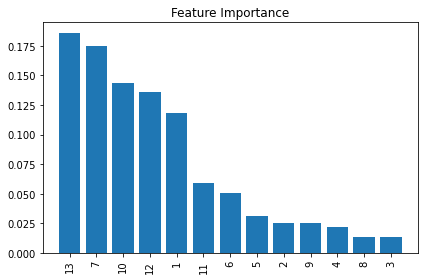

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_wine = pd.read_csv('wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
			random_state=0, stratify=y)
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,  random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices],  align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Del gráfico anterior se elegirían las 4 o cinco primeras características: 13, 7, 10, 12, 1.

## Extracción
Se genera un espacio nuevo de dimensiones a partir del original, pero con menos dimensiones manteniendo toda la
información del espacio original

Tipos
- PCA
- LDA
- Kernel no lineal
- Otros

### PCA
Análisis de componentes principales

Buscar una matriz de transformaciones desde el espacio original al espacio buscado (W), realizar la transformación
z = Wx, dónde z es el nuevo vector y x el antiguo.
El algoritmo PCA intenta buscar las direcciones de máxima varianza en el espacio de partida y proyectarlo en otro
con menos dimensiones

Los ejes (componentes principales) serán ortogonales en el nuevo espacio, se interpretan como las direcciones de
máxima varianza con respecto a los ejes ya definidos.
Hay que tener en cuenta que las direcciones (las componentes extraídas) son muy dependientes al escalado de los datos,
por lo que se tienen que estandarizar los datos antes si queremos dar la misma importancia a todas las características
originales.

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',  'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  stratify=y,  random_state=0)

# Standardizing the data.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

pca = PCA(n_components=2)   # n_components se puede ajustar 2, 6 y 7
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_std, y_train)
print("Tasa:", lr.score(X_test_std, y_test))

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)
print("Tasa:", lr.score(X_test_pca, y_test))


Tasa: 1.0
Tasa: 0.9259259259259259


### LDA
Análisis discriminante lineal.

Este mecanismo se basa en usar un método supervisado frente al no supervisado del anterior.
Esta técnica la podemos usar con datos no regularizados.
Para que el método sea óptimo hay que tener en cuenta que las clases deben tener idéntica matriz de covarianza y los
ejemplos deben ser estadísticamente independientes.
Pero incluso sin que se cumplan estas restricciones el algoritmo funciona bien.

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',  'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  stratify=y,  random_state=0)

# Standardizing the data.
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

lda = LDA(n_components=2) # n_components se puede ajustar
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

print("Tasa:", lr.score(X_test_lda, y_test))

Tasa: 1.0


### Kernel no lineal
Gestionar problemas no lineares proyectándolos en un espacio mayor que sea lineal y posteriormente realizar la
reducción de dimensionalidad con PCA al espacio deseado

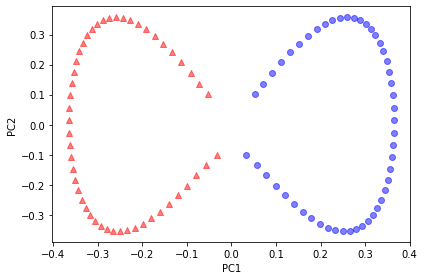

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA


X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

### Otros
- **PCA Incremental**. Permite dividir el conjunto de entrada en partes más pequeñas y alimentar el algoritmo con ellas.
De esta manera se puede entrenar de forma online y con datasets muy grandes.
- **LLE**. Se mide primero cada instancia de forma lineal con sus vecinos y se busca una representación de menor
dimensionalidad que preserve dichas relaciones.
- **Proyecciones aleatorias**. Se elige al azar las dimensiones.
- **MDS**. Reduce la dimensionalidad preservando la distancia entre las instancias.
- **Isomapas**. Crea un grafo de interconexión con los vecinos e intentar mantener la distancia geodésica.
